<a href="https://colab.research.google.com/github/Inishpy/DeepLearningWork/blob/main/nb_qlora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Packages

In [ ]:
!pip install -U accelerate peft transformers einops datasets bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstallin

In [ ]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes"

accelerate==0.27.2
bitsandbytes==0.42.0
datasets==2.17.1
einops==0.7.0
peft==0.8.2
tensorflow-datasets==4.9.4
transformers==4.37.2
vega-datasets==0.9.0


## Set a seed for reproducibility of the training process

In [ ]:
from transformers import set_seed

set_seed(42)

# Load model and tokenizer

## Load model in 4 bit

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
    # FA2 does not work yet
    # attn_implementation="flash_attention_2",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

The repository for microsoft/phi-2 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/microsoft/phi-2.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


RuntimeError: Failed to import transformers.models.transfo_xl.configuration_transfo_xl because of the following error (look up to see its traceback):
No module named 'transformers.models.transfo_xl.configuration_transfo_xl'

In [ ]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layern

## Load tokenizer

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)    # fast tokenizer sometimes ignores the added tokens

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
len(tokenizer)

50295

## Add ChatML tokens to tokenizer

In [ ]:
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.config.eos_token_id = tokenizer.eos_token_id

Note: there is no need to rezise the token embeddings, phi-2 already has embeddings sized for additional tokens. The model's vocab. size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings.

In [ ]:
model.model.embed_tokens

Embedding(51200, 2560)

## Prepare LoRA adapters

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

lora_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense" ],
    modules_to_save = ["lm_head", "embed_tokens"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

model.config.use_cache = False

# Load and preprocess dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("g-ronimo/riddles_evolved")
dataset = dataset["train"].train_test_split(test_size=0.1)

In [ ]:
dataset

In [ ]:
dataset["train"][0]

## Apply ChatML format and tokenize

In [ ]:
import os
from functools import partial

# Format (chatML) and tokenize dataset
templates=[
    "<|im_start|>assistant\n{msg}<|im_end|>",
    "<|im_start|>user\n{msg}<|im_end|>"
]
IGNORE_INDEX=-100

def tokenize(input, max_length):
    input_ids, attention_mask, labels = [], [], []

    for i,msg in enumerate(input["messages"]):
        isHuman = i%2==0
        msg_chatml=templates[isHuman].format(msg=msg)
        msg_tokenized=tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=1024), # max sample length 1024 tokens, enough for this dataset
    batched=False,
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)

Map (num_proc=2):   0%|          | 0/1513 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/169 [00:00<?, ? examples/s]

longest sample: 952 tokens


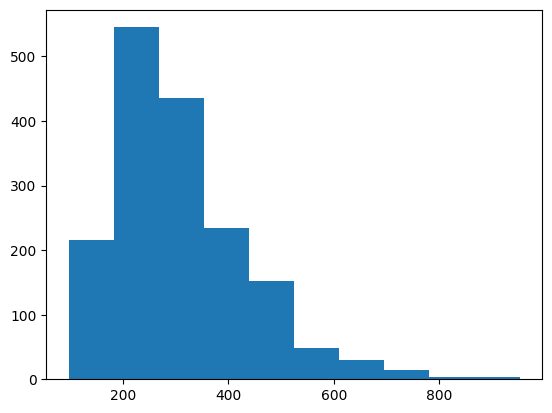

In [ ]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])]
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)
plt.show()

## Define a collate function, train on answers only

In [ ]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])

    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend( pad_len * [tokenizer.pad_token_id] )
        labels.extend( pad_len * [IGNORE_INDEX] )
        attention_mask.extend( pad_len * [0] )

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch

# Train

## Set hyperparameters

In [ ]:
from transformers import TrainingArguments, Trainer

# dataset-specific parameters
bs=1     # batch size for training
bs_eval=16    # batch size for evaluation
ga_steps=16  # gradient accumulation steps
lr=0.00002  # learning rate
epochs=20

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=True,
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)

ValueError: Your setup doesn't support bf16/gpu. You need torch>=1.10, using Ampere GPU with cuda>=11.0

In [ ]:
# log to a specific wandb project
import wandb
run = wandb.init(
    project="phi2",
    name="testrun",
)

## Start training

In [ ]:
trainer.train()

# After training: Merge LoRA adapters with base model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

# base model
base_path="microsoft/phi-2"

# adapters: path to folder with adapter_model.safetensors
adapter_path="out/checkpoint-1880"

# where to save merged model
save_to="trained_model"

# Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before training
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

# Add ChatML template to tokenizer
tokenizer.chat_template="{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

base_model.config.eos_token_id = tokenizer.eos_token_id

# Set a default Generation configuration: Llama precise
generation_config = GenerationConfig(
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)
generation_config.save_pretrained(save_to)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Inference of trained model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

model_path="trained_model"
question="Hello, who are you?"

model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
tokenizer = AutoTokenizer.from_pretrained(model_path)

messages=[
    {"role": "user", "content": question}
]

input_tokens = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

output_tokens = model.generate(input_tokens)
output = tokenizer.decode(
    output_tokens[0][len(input_tokens[0]):],
    skip_special_tokens=True
    )

print(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


I am an artificial intelligence language model designed to help answer questions and provide information. I don't have a specific identity or creator like humans do. If there's any particular question you'd like me to help with, feel free to ask!


# Upload model to hub

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import

# Load model and tokenizer
modelpath="trained_model"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(modelpath)

# Upload
model.push_to_hub("g-ronimo/phi-2_riddles-evolved")
tokenizer.push_to_hub("g-ronimo/phi-2_riddles-evolved")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]